# Phase Diagram of the Quark-Meson Model using the FV and FD method

---

Here we compare the numerical result of both methods.

---
*Author: Phillip Lakaschus*

# Libraries


---

In [1]:
import time
import numpy as np # needed for efficient array manipulation
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp # import the time integrator
from scipy import integrate
from findiff import FinDiff

# FV - linear domain ($\sigma$)

In [4]:
# Define energies, see also Eq. B5
def Esig(x, u, ux, t):
  return np.sqrt(cutoffr**2*np.exp(-2*t) + ux/dx)

def Epion(x, u, t):
  """ If x == 0 then u = 0 since u is anti-symmetric """
  udx = u[1:]/x[1:]
  return np.sqrt(cutoffr**2*np.exp(-2*t) + np.append(udx[0] - (udx[1] - udx[0]), udx))

def Epsi(x, t):
  return np.sqrt(cutoffr**2*np.exp(-2*t) + h**2*x**2)

# convection flux
def flux(x, u, t, T):
  Ep = Epion(x, u, t)
  #print(u)
  return  (Nf-1)/(12*np.pi**2)*cutoffr**5*np.exp(-5*t)*(1+2/(np.exp(Ep/T) - 1))/Ep 

# characteristic velocity/local propagation speed
def char(x, u, t, T):
  Ep = Epion(x, u, t)
  chr = ( (Nf-1)/(24*np.pi**2*x)*cutoffr**5*np.exp(-5*t)*(-2/(T*Ep**2)*np.exp(Ep/T)/(np.exp(Ep/T) - 1)*1/(np.exp(Ep/T) - 1) \
                                                         - 1/Ep**3*(1+2/(np.exp(Ep/T) - 1))) )[1:]
  return np.append(chr[0] - (chr[1] - chr[0]), chr)

# diffusion term
def diff(x, u, ux, t, T):
  Es = Esig(x, u, ux, t)
  return -1/2*cutoffr**5/(6*np.pi**2)*np.exp(-5*t)*(1+2/(np.exp(Es/T) - 1))/Es 

# source term
def src(x, t, T, mu):
  Eps = Epsi(x, t)
  return 1/np.pi**2*cutoffr**5*np.exp(-5*t)*(1/Eps*(np.tanh((Eps - mu)/(2*T)) + np.tanh((Eps + mu)/(2*T)))) 

# source term, derivative already taken
def src2(x, t, T, mu):
  Eps = Epsi(x, t)
  return 2*x/np.pi**2*cutoffr**5*np.exp(-5*t)*h**2/(4*Eps**3*T)*( Eps*( 1/(np.cosh((Eps - mu)/(2*T))**2 + 1/(np.cosh((Eps + mu)/(2*T))**2 )) ) - 2*T*\
                                                               (np.tanh((Eps - mu)/(2*T)) + np.tanh((Eps + mu)/(2*T)))) 

# generalised minmod limiter
def gen_minmod(a, b, c):
  th = 1
  maximum = np.maximum(th*a, np.maximum(b, th*c))
  minimum = np.minimum(th*a, np.minimum(b, th*c))
  hs_pos = np.heaviside(a, 1)*np.heaviside(b, 1)*np.heaviside(c, 1)
  hs_neg = np.heaviside(-a, 1)*np.heaviside(-b, 1)*np.heaviside(-c, 1)
  return minimum*hs_pos + maximum*hs_neg

def pion_mass(x, u, min_pos):
    m_pi = np.sqrt(d_dx(u)[min_pos]/x[min_pos])*cutoff
    return m_pi

def sigma_mass(x, u, min_pos):
    m_sigma = np.sqrt(d2_dx2(u)[min_pos])*cutoff
    return m_sigma

In [5]:
def dudt(u, t, T, mu):
  global t_stop
  
  low_bnd = -u[0] # ghost cells: Use antisymmetry
  up_bnd = u[-1] + (u[-1]-u[-2]) # ghost cells: linearly extrapolated potential
  u = np.append(low_bnd, np.append(u, up_bnd)) # add boundaries to potential
  
  # minmod limiter
  limiter = gen_minmod((u[1:-1] - u[:-2])/dx, (u[2:] - u[:-2])/(2*dx),  (u[2:] - u[1:-1])/dx)
  
  # definition of intermediate values, u_(j-1/2), see Eq. 4.5
  uLForw = 0 
  uLCent = u[1:-1] + dx/2*limiter
  uL = np.append(uLForw, uLCent)
  
  # definition of intermediate values, u_(j+1/2)
  uRBack = u[-1] - (u[-1] - u[-2])/2
  uRCent = np.append(0, u[2:-1] - dx/2*limiter[1:])
  uR = np.append(uRCent, uRBack)

  # calculate the propagation speeds
  charL = char(x, uL, t, T)
  charR = char(x, uR, t, T)
  prop = (np.abs(charL) >= np.abs(charR)).astype(int)*np.abs(charL) \
       + (np.abs(charL) < np.abs(charR)).astype(int)*np.abs(charR)
  
  fu_interface = (flux(x, uL, t, T) + flux(x, uR, t, T))/2 - prop/2*(uR - uL)
  
  Pp = 1/2*(diff(xcR[:-1], u[1:-1], u[2:] - u[1:-1], t, T) + diff(xcR[1:], u[2:], u[2:] - u[1:-1], t, T))
  Pm = 1/2*(diff(xcL[:-1], u[:-2], u[1:-1] - u[:-2], t, T) + diff(xcL[1:], u[1:-1], u[1:-1] - u[:-2], t, T))
  # complete flow equation
  dudt = (fu_interface[:-1] - fu_interface[1:])/dx + (Pp - Pm)/dx + src2(xc, t, T, mu) # + (source[1:] - source[:-1])/dx # #
  if t >= t_stop:
    print("flow time: ", t)
    t_stop += 0.1
  return dudt

We only solve the derivative of the effective potential.
The following function reconstructs the effective potential from the derivative:

In [6]:
def construct_potential(x, u):
    return integrate.cumtrapz(u, x, initial=0)

We use scipy.odeint to integrate the flow equation. 

In [7]:
def solve(T, mu):
    print((T, mu))
    return solve_ivp(lambda t, y: dudt(y, t, T, mu), (t[0], t[-1]), u0, method='BDF', rtol=1e-13, atol=1e-13)
  
def solve(T, mu):
    print((T, mu))
    return odeint(dudt, u0, t, args=(T, mu), mxstep=200000, rtol= 1e-13, atol=1e-13)

Main Program:

In [8]:
if __name__ == "__main__":
  # All quan,tities are rendered dimensionless with respect to the cutoff
  cutoff = 1000
  cutoffr = 1 # rescaled cutoff; Set cutoffr = 1000 and cutoff = 1 for dimensionful calculation
  
  N = 300 # number of gridpoints
  xmax = 180/cutoff
  x = np.linspace(0, xmax, N+1)
  N_t = 100
  t_max = 3.5#3.5 # This corresponds to roughly k = 30 MeV
  t_stop = 0
  t = np.linspace(0, t_max, N_t)
  dx = x[1] - x[0]

  xc = 0.5*np.array(x[:-1] + x[1:]) # array with values in-between grid points
  xcL = np.append(xc[0] - dx, xc)
  xcR = np.append(xc, xc[-1] + dx)
  
  # define derivatives, later used the determine the pion and sigma mass
  acc = 2
  d_dx = FinDiff(0, dx, acc = acc)
  d2_dx2 = FinDiff(0, dx, 2, acc = acc)

  # Model parameters
  Nf = 4  # N of O(N), not number of flavors
  m_lam, lam, c, h = 794/cutoff, 2, 1750000/cutoff**3, 3.2 # taken from Ref. [1]

  v0 = (1/2*m_lam**2*xc**2 + 1/4*lam*xc**4) # derivative of initial potential
  u0 = (m_lam**2*xc + lam*xc**3) # initial effective potential
  expl_sym_br = c*xc # explicit symmetry breaking term

Test: The integral of u0 must the same as v0

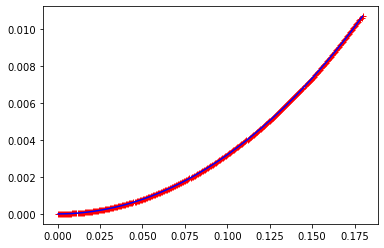

In [9]:
  plt.plot(xc, v0, "+", color="red")
  plt.plot(xc, construct_potential(xc, u0), color="b")
  plt.show()

Now let's solve the flow equation for $T = 5$ MeV and $\mu = 0$.

In [10]:
  start = time.time()  
  t_stop = 0
  sol_example = solve(5/cutoff, 0/cutoff)

  print("Duration: "+str(time.time()-start)[:2]+" s")

(0.005, 0.0)
flow time:  0.0


<ipython-input-4-01a4eed2f6c5>:22: RuntimeWarning: divide by zero encountered in true_divide
  chr = ( (Nf-1)/(24*np.pi**2*x)*cutoffr**5*np.exp(-5*t)*(-2/(T*Ep**2)*np.exp(Ep/T)/(np.exp(Ep/T) - 1)*1/(np.exp(Ep/T) - 1) \


flow time:  0.10044936442425031
flow time:  0.20017109988706946
flow time:  0.30375553862445714
flow time:  0.4038127886723012
flow time:  0.5038512578945167
flow time:  0.601550544481011
flow time:  0.7001347899662995
flow time:  0.800130031583927
flow time:  0.9000541622692243
flow time:  1.0001072748155635
flow time:  1.100468975599526
flow time:  1.2004742843510816
flow time:  1.300121639706176
flow time:  1.4005003351137184
flow time:  1.500392140973708
flow time:  1.6006383470636103
flow time:  1.7006710222377954
flow time:  1.8003180887178105
flow time:  1.900708125771683
flow time:  2.000316407963636
flow time:  2.100087853110995
flow time:  2.2000513740683054
flow time:  2.3002642468627243
flow time:  2.4000358826727646
flow time:  2.5001105664684258
flow time:  2.600921066172818
flow time:  2.70085326612083
flow time:  2.800473748857034
flow time:  2.9007119977038784
flow time:  3.001642442615939
flow time:  3.1010758434844377
flow time:  3.2004811860082927
flow time:  3.3011

**Plot the result:**

In [11]:
"""Taken from https://colab.research.google.com/drive/131wXGA8h8d7llSZxZJ6R4e8nz0ih1WPG#scrollTo=5zVG8JcR4CS2"""
from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axes, and the plot element
fig, ax = plt.subplots()
plt.close()
ax.set_xlim(( 0, 0.12))
#ax.set_ylim((-0.0001, 0.00021))
ax.set_ylim((-0.01, 0.011))
line2, = ax.plot([], [], lw=2)

# animation function: this is called sequentially
def animate(i):
  #line2.set_data(xc, construct_potential(xc, sol_example[i]))
  line2.set_data(xc, sol_example[i])
  return (line2,)

anim = animation.FuncAnimation(fig, animate, frames=N_t, blit=True)

rc('animation', html='jshtml')
anim

A closer look at the IR potential:

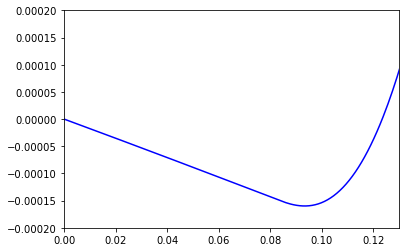

Minimum of the potential:  92.99999999999999
Pion mass:  135.68523220531102
Sigma mass:  507.07683040933927


In [12]:
axes = plt.gca()
axes.set_xlim([0.,.13])
axes.set_ylim([-0.0002, 0.0002])
plt.plot(xc, construct_potential(xc, sol_example[-1]) - expl_sym_br, c='b')
plt.show()
u = construct_potential(xc, sol_example[-1])
min_pos = np.argmin(u - expl_sym_br)
f_pi = min_pos*dx*cutoff
m_pi = pion_mass(xc, u, min_pos)
m_sig = sigma_mass(xc, u, min_pos)
print("Minimum of the potential: ", f_pi)
print("Pion mass: ", m_pi)
print("Sigma mass: ", m_sig)

# FV: $\sigma^2$ domain and naive linear extrapolation 

In [14]:
def main_old(T, mu):
  def Esig(x, u, ux, t):
    return np.sqrt(cutoffr**2*np.exp(-2*t) + 2*u + 4*x*ux/dx)

  def Epion(u, t):
    return np.sqrt(cutoffr**2*np.exp(-2*t) + 2*u)

  def Epsi(x, t):
    return np.sqrt(cutoffr**2*np.exp(-2*t) + h**2*x)

  # convection flux
  def flux(u, t, T):
    Ep = Epion(u, t)
    return 1/2*(Nf-1)/(6*np.pi**2)*cutoffr**5*np.exp(-5*t)*(1+2/(np.exp(Ep/T) - 1))/Ep

  # characteristic velocity/local propagation speed
  def char(u, t, T):
    Ep = Epion(u, t)
    return 1/2*(Nf-1)/(6*np.pi**2)*cutoffr**5*np.exp(-5*t)*(-2/(T*Ep**2)*np.exp(Ep/T)/(np.exp(Ep/T) - 1)*1/(np.exp(Ep/T) - 1) \
                                                          - 1/Ep**3*(1+2/(np.exp(Ep/T) - 1)))

  # diffusion term
  def diff(x, u, ux, t, T):
    Es = Esig(x, u, ux, t)
    return -1/2*cutoffr**5/(6*np.pi**2)*np.exp(-5*t)*(1+2/(np.exp(Es/T) - 1))/Es

  # source term
  def src(x, t, T, mu):
    Eps = Epsi(x, t)
    return 1/np.pi**2*cutoffr**5*np.exp(-5*t)*(1/Eps*(np.tanh((Eps - mu)/(2*T)) + np.tanh((Eps + mu)/(2*T)))) 

  # source term, derivative already taken
  def src2(x, t, T, mu):
    Eps = Epsi(x, t)
    return 1/np.pi**2*cutoffr**5*np.exp(-5*t)*h**2/(4*Eps**3*T)*( Eps*( 1/(np.cosh((Eps - mu)/(2*T))**2 + 1/(np.cosh((Eps + mu)/(2*T))**2 )) ) - 2*T*\
                                                                (np.tanh((Eps - mu)/(2*T)) + np.tanh((Eps + mu)/(2*T))))

  # generalised minmod limiter
  def gen_minmod(a, b, c):
    th = 1
    maximum = np.maximum(th*a, np.maximum(b, th*c))
    minimum = np.minimum(th*a, np.minimum(b, th*c))
    hs_pos = np.heaviside(a, 1)*np.heaviside(b, 1)*np.heaviside(c, 1)
    hs_neg = np.heaviside(-a, 1)*np.heaviside(-b, 1)*np.heaviside(-c, 1)
    return minimum*hs_pos + maximum*hs_neg

  def pion_mass(u, min_pos):
      m_pi = np.sqrt(2*d_dx(u)[min_pos])*cutoff
      return m_pi

  def sigma_mass(xc, u, min_pos):
      m_sigma = np.sqrt(2*d_dx(u)[min_pos] + 4*xc[min_pos]*d2_dx2(u)[min_pos])*cutoff
      return m_sigma

  def dudt(u, t, T, mu):
    low_bnd, up_bnd = u[0]-(u[1] - u[0]), u[-1]+(u[-1]-u[-2]) # ghost cells: linearly extrapolated potential
    u = np.append(low_bnd, np.append(u, up_bnd)) # add boundaries to potential
    
    # minmod limiter
    limiter = gen_minmod((u[1:-1] - u[:-2])/dx, (u[2:] - u[:-2])/(2*dx),  (u[2:] - u[1:-1])/dx)
    
    # definition of intermediate values, u_(j-1/2), see Eq. 4.5
    uLForw = u[0] + (u[1] - u[0])/2 
    uLCent = u[1:-1] + dx/2*limiter
    uL = np.append(uLForw, uLCent)
    
    # definition of intermediate values, u_(j+1/2)
    uRBack = u[-1] - (u[-1] - u[-2])/2
    uRCent = u[1:-1] - dx/2*limiter
    uR = np.append(uRCent, uRBack)
    
    # calculate the propagation speeds
    charL = char(uL, t, T)
    charR = char(uR, t, T)
    prop = (np.abs(charL) >= np.abs(charR)).astype(int)*np.abs(charL) \
        + (np.abs(charL) < np.abs(charR)).astype(int)*np.abs(charR)
    
    # see Eq. 4.4
    fu_interface = (flux(uL, t, T) + flux(uR, t, T))/2 - prop/2*(uR - uL)

    # diffusion term; see Eq. 4.14    
    Pp = 1/2*(diff(xcR[:-1], u[1:-1], u[2:] - u[1:-1], t, T) + diff(xcR[1:], u[2:], u[2:] - u[1:-1], t, T))
    Pm = 1/2*(diff(xcL[:-1], u[:-2], u[1:-1] - u[:-2], t, T) + diff(xcL[1:], u[1:-1], u[1:-1] - u[:-2], t, T))

    #source = src(x, t, T, mu)
    
    # complete flow equation
    dudt =  (fu_interface[:-1] - fu_interface[1:])/dx + (Pp - Pm)/dx + src2(xc, t, T, mu) # + (source[1:] - source[:-1])/dx #
    return dudt

  def construct_potential(x, u):
      return integrate.cumtrapz(u, x, initial=0)

  def solve(T, mu):
      print((T, mu))
      return odeint(dudt, u0, t, args=(T, mu), mxstep=200000, rtol= 1e-12, atol=1e-12)

  # All quan,tities are rendered dimensionless with respect to the cutoff
  cutoff = 1000
  cutoffr = 1  # rescaled cutoff; Set cutoffr = 1000 and cutoff = 1 for dimensionful calculation
  
  N = 300 # number of gridpoints
  xmax = 180**2/cutoff**2
  x = np.linspace(0, xmax, N+1)
  N_t = 100
  t_max = 3.5 # This corresponds to roughly k = 30 MeV
  t = np.linspace(0, t_max, N_t)
  dx = x[1] - x[0]
  # Shift grid to the left such that xc start at x = 0 + eps
  eps = 0.001/cutoff**2
  x = x - dx/2 + eps

  xc = 0.5*np.array(x[:-1]+x[1:]) # array with values in-between grid points
  xcL = np.append(xc[0] - dx, xc)
  xcR = np.append(xc, xc[-1] + dx)
  
  # define derivatives, later used the determine the pion and sigma mass
  acc = 2
  d_dx = FinDiff(0, dx, acc = acc)
  d2_dx2 = FinDiff(0, dx, 2, acc = acc)

  # Model parameters
  Nf = 4  # N of O(N), not number of flavors
  m_lam, lam, c, h = 794/cutoff, 2, 1750000/cutoff**3, 3.2 # taken from Ref. [1]

  u0 = (1/2*m_lam**2 + 1/2*lam*xc) # derivative of initial potential
  v0 = (1.0/2.0*m_lam**2*xc + lam/4.0*xc**2) # initial effective potential
  expl_sym_br = c*np.sqrt(xc) # explicit symmetry breaking term

  plt.plot(np.sqrt(xc), v0, "+", color="red")
  plt.plot(np.sqrt(xc), construct_potential(xc, u0), color="b")
  plt.show()

  start = time.time()  

  sol_example = solve(T/cutoff, mu/cutoff)

  print("Duration: "+str(time.time()-start)[:2]+" s")

  axes = plt.gca()
  axes.set_xlim([0.,.13])
  axes.set_ylim([-0.0002, 0.0002])
  plt.plot(np.sqrt(xc), construct_potential(xc, sol_example[-1]) - expl_sym_br, c='b')
  plt.show()
  u = construct_potential(xc, sol_example[-1])
  min_pos = np.argmin(u - expl_sym_br)
  f_pi = np.sqrt(min_pos*dx)*cutoff
  m_pi = pion_mass(u, min_pos)
  m_sig = sigma_mass(xc, u, min_pos)
  print("Minimum of the potential: ", f_pi)
  print("Pion mass: ", m_pi)
  print("Sigma mass: ", m_sig)
  return (xc, f_pi, m_pi, m_sig, sol_example)

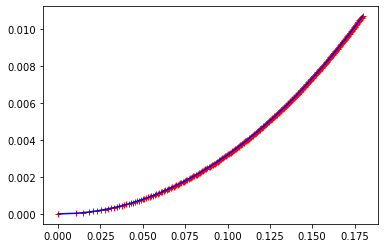

(0.005, 0.0)
Duration: 55 s


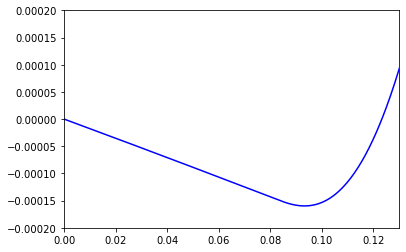

Minimum of the potential:  93.53074360871936
Pion mass:  138.42969761182948
Sigma mass:  510.72607869638176


In [15]:
xc2, f_pi2, m_pi2, m_sig2, sol_example2 = main_old(5, 0)

In [17]:
"""Taken from https://colab.research.google.com/drive/131wXGA8h8d7llSZxZJ6R4e8nz0ih1WPG#scrollTo=5zVG8JcR4CS2"""
from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axes, and the plot element
fig, ax = plt.subplots()
plt.close()
ax.set_xlim(( 0, 120))
ax.set_ylim((-0.0001, 0.0008))
line2, = ax.plot([], [], lw=2)
line3, = ax.plot([], [], lw=2)

# animation function: this is called sequentially
def animate(i):
  line2.set_data(np.sqrt(xc2)*cutoff, construct_potential(xc2, sol_example2[i])+0.00001)
  line3.set_data(xc*cutoff, construct_potential(xc, sol_example[i]))
  return (line2,line3,)

anim = animation.FuncAnimation(fig, animate, frames=N_t, blit=True)

rc('animation', html='jshtml')
anim

-> Both approaches agree pretty well! (Note: Blue line displaced by small amount to increase visibility)

# Old Method: Finite Differences

In [18]:
def main_fd(T, mu):
  def Esig(x, ux, uxx, t):
    return np.sqrt(cutoffr**2*np.exp(-2*t) + 2*ux + 4*x*uxx)

  def Epion(ux, t):
    return np.sqrt(cutoffr**2*np.exp(-2*t) + 2*ux)

  def Epsi(x, t):
    return np.sqrt(cutoffr**2*np.exp(-2*t) + h**2*x)

  def pion_mass(u, min_pos):
      m_pi = np.sqrt(2*d_dx(u)[min_pos])*cutoff
      return m_pi

  def sigma_mass(xc, u, min_pos):
      m_sigma = np.sqrt(2*d_dx(u)[min_pos] + 4*xc[min_pos]*d2_dx2(u)[min_pos])*cutoff
      return m_sigma

  def dudt(u, t, T, mu):
    #print("t: ", t)
    ux = d_dx(u)
    uxx = d2_dx2(u)
    Ep = Epion(ux, t)
    Es = Esig(x, ux, uxx, t)
    Eq = Epsi(x, t)
    dudt = -cutoffr**5*np.exp(-5*t)/(12*np.pi**2)*(3.0/Ep*(1.0/np.tanh(Ep/(2*T)))
                            + 1.0/(Es)*(1.0/np.tanh(Es/(2*T)))
                            - 12.0/Eq*(np.tanh((Eq - mu)/ (2*T))
                            + np.tanh((Eq + mu)/(2*T))))
    return dudt

  #def solve(T, mu):
  #    print((T, mu))
  #    return odeint(dudt, v0, t, args=(T, mu), mxstep=200000, rtol= 1e-12, atol=1e-12)

  def solve(T, mu):
      print((T, mu))
      return solve_ivp(lambda t, y: dudt(y, t, T, mu), (t[0], t[-1]), v0, method='BDF', t_eval = t, rtol=1e-13, atol=1e-13).y.T

  # All quan,tities are rendered dimensionless with respect to the cutoff
  cutoff = 1000
  cutoffr = 1  # rescaled cutoff; Set cutoffr = 1000 and cutoff = 1 for dimensionful calculation
  
  N = 300 # number of gridpoints
  xmax = 180**2/cutoff**2
  x = np.linspace(0, xmax, N)
  N_t = 100
  t_max = 3.5 # This corresponds to roughly k = 50 MeV
  t = np.linspace(0, t_max, N_t)
  dx = x[1] - x[0]
  
  # define derivatives, later used the determine the pion and sigma mass
  acc = 2
  d_dx = FinDiff(0, dx, acc = acc)
  d2_dx2 = FinDiff(0, dx, 2, acc = acc)

  # Model parameters
  Nf = 4  # N of O(N), not number of flavors
  m_lam, lam, c, h = 794/cutoff, 2, 1750000/cutoff**3, 3.2 # taken from Ref. [1]

  v0 = (1.0/2.0*m_lam**2*x + lam/4.0*x**2) # initial effective potential
  expl_sym_br = c*np.sqrt(x) # explicit symmetry breaking term

  start = time.time()  

  sol_example = solve(T/cutoff, mu/cutoff)

  print("Duration: "+str(time.time()-start)[:2]+" s")

  axes = plt.gca()
  axes.set_xlim([0.,0.12])
  axes.set_ylim([-0.0002, 0.0002])
  plt.plot(np.sqrt(x), sol_example[-1] - 0*expl_sym_br - sol_example[-1][0], c='b')
  plt.show()
  u = sol_example[-1] - sol_example[-1][0]
  #print(np.sqrt(x))
  #print(u)
  min_pos = np.argmin(u - expl_sym_br)
  f_pi = np.sqrt(min_pos*dx)*cutoff
  m_pi = pion_mass(u, min_pos)
  m_sig = sigma_mass(x, u, min_pos)
  print("Minimum of the potential: ", f_pi)
  print("Pion mass: ", m_pi)
  print("Sigma mass: ", m_sig)
  return (x, f_pi, m_pi, m_sig, sol_example)

(0.005, 0.0)
Duration: 11 s


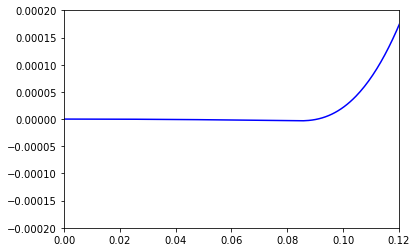

Minimum of the potential:  93.10690802013691
Pion mass:  134.34979586766943
Sigma mass:  505.8893786867602


In [19]:
(x_fd, f_pi_fd, m_pi_fd, m_sig_fd, sol_example_fd) = main_fd(5, 0)

# Comparison

In [20]:
print("Condensates: ", (f_pi, f_pi2, f_pi_fd))
print("Pion masses: ", (m_pi, m_pi2, m_pi_fd))
print("Sigma masses: ", (m_sig, m_sig2, m_sig_fd))

Condensates:  (92.99999999999999, 93.53074360871936, 93.10690802013691)
Pion masses:  (135.68523220531102, 138.42969761182948, 134.34979586766943)
Sigma masses:  (507.07683040933927, 510.72607869638176, 505.8893786867602)


In [21]:
"""Taken from https://colab.research.google.com/drive/131wXGA8h8d7llSZxZJ6R4e8nz0ih1WPG#scrollTo=5zVG8JcR4CS2"""
from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axes, and the plot element
fig, ax = plt.subplots()
plt.close()
ax.set_xlim(( 0, 120))
ax.set_ylim((-0.0001, 0.0001))
line2, = ax.plot([], [], lw=2)
line3, = ax.plot([], [], lw=2)
line4, = ax.plot([], [], lw=2)
# animation function: this is called sequentially
def animate(i):
  #line2.set_data(xc, construct_potential(xc, sol_example[i]))
  line2.set_data(np.sqrt(xc2)*cutoff, construct_potential(xc2, sol_example2[i])+0.000002) # small number added to discriminate curves
  line3.set_data(xc*cutoff, construct_potential(xc, sol_example[i])+0.000004)
  line4.set_data(np.sqrt(x_fd)*cutoff, sol_example_fd[i] - sol_example_fd[i][0])
  return (line2,line3,)

anim = animation.FuncAnimation(fig, animate, frames=N_t, blit=True)
print("Note: Small constant has been added to distinguish the different lines")
rc('animation', html='jshtml')
anim

Note: Small constant has been added to distinguish the different lines
